# Statistische Analyse in Python mittels Pingouin

In [1]:
import numpy as np
import pandas as pd
import pingouin as pg

import matplotlib.pyplot as plt
import seaborn as sns
from statannot import add_stat_annotation

import biopsykit as bp

from IPython.display import Markdown

%load_ext autoreload
%autoreload 2
%matplotlib widget

**Pingouin**: Open-Source Bibliothek zur statistischen Analyse in Python, die auf *pandas* und *numpy* basiert.

Installation: `pip install pingouin`  
Link: https://pingouin-stats.org/  
Tutorial: https://pingouin-stats.org/guidelines.html

Import: `import pingouin as pg`

In [2]:
sns.set_theme(style="ticks")
sns.set_palette(sns.color_palette("light:#003865", n_colors=4)[::-1])
plt.close('all')

# parameter for add_stat_annotation
pvalue_thres = [[1e-3, "***"], [1e-2, "**"], [0.05, "*"]]

<div class="alert alert-block alert-info">
    <b>Hinweis:</b> Genauso wie Seaborn ist es auch bei Pingouin von Vorteil, wenn die Daten im <i>Long-Format</i> vorliegen!
</div>

## Daten importieren

Datensatz aus Richer et al. "Tackling Acute Stress: Evaluating the Cold Face Test as a Potential Mechanism for Stress-reducing Wearables"
HR(V), Cortisol und Fragebögen während der Durchführung des MIST mit zwei Gruppen: Kontrollgruppe und Interventionsgruppe
* HR(V): Variablen Herzrate (HR), RMSSD, pNN50, SD1/SD2  pro MIST Phase (1-3) und pro MIST Subphase (Baseline (BL), Cold Face Intervention (CFI), Arithmetic Tasks (AT), Feedback (FB)), jeweils absolut und relativ (z.B. $\text{HR}_{rel}$, normalisiert pro Subject vor Beginn des Stressors)
* Fragebogen: MDBF (Multidimensionaler Bedindlichkeitsfragebogen, jeweils *pre* und *post* Stress)
* Cortisol: 7 Speichelproben an den Zeitpunkten -27 (S0, zur Kontrolle für hohe Baseline), 0, 30, 40, 50, 60, 70 (min relativ zu MIST-Start)

### HR(V)

In [3]:
df_hr = pd.read_csv("data/hr_sample.csv", index_col=["condition", "subject", "phase", "subphase"])
df_hr.head()

HR      RMSSD      pNN50  \
condition    subject phase subphase                                    
Intervention 1       MIST1 BL        92.267432  22.554093   5.494505   
                           AT        92.390654  31.981018  15.994550   
                           CFI       85.288600  29.278240  10.236686   
                           FB        91.236676  25.647301   8.947368   
                     MIST2 BL        91.489228  20.316695   0.000000   

                                      SD1/SD2     HR_rel  RMSSD_rel  \
condition    subject phase subphase                                   
Intervention 1       MIST1 BL        0.320845  -4.601992  10.334854   
                           AT        0.322195  -4.474589  56.451465   
                           CFI       0.280812 -11.817612  43.229445   
                           FB        0.448421  -5.667722  25.466858   
                     MIST2 BL        0.297082  -5.406600  -0.610524   

                                      pNN50_rel  SD1/SD2_rel  
condition    subject phase subphase                           
Intervention 1       MIST1 BL         51.865576    23.095973  
                           AT        342.081934    23.614102  
                           CFI       182.937251     7.737000  
                           FB        147.301102    72.042135  
                     MIST2 BL       -100.000000    13.979008

### Fragebögen

In [4]:
df_mood = pd.read_csv("data/mood_sample.csv", index_col=["condition", "subject", "time", "type"])
df_mood.head()

MDBF
condition    subject time type              
Intervention 1       pre  awake_tired     29
                          calm_nervous    32
                          good_bad        34
                     post awake_tired     30
                          calm_nervous    28

### Cortisol

In [5]:
df_cort_raw = pd.read_csv("data/cortisol_sample.csv", index_col=["condition", "subject"])
saliva_times = [-27, 0, 30, 40, 50, 60, 70]

# Umwandeln ins Long-Format
df_cort_raw = pd.DataFrame(df_cort_raw.stack())
df_cort_raw.columns = ["cortisol"]
df_cort_raw.index = df_cort_raw.index.rename('sample', level=2)

# Aufteilen der Cortisol-Werte in Wert davor (Sample 1) und maximaler Wert pro Subject danach (Samples 2 bis 6)
cort_pre = df_cort_raw.unstack(level='sample').iloc[:, 1]
cort_post = df_cort_raw.unstack(level='sample').iloc[:, 2:].max(axis=1)
df_cort_inc = pd.concat([cort_pre, cort_post], axis=1, keys=['pre', 'post'], names=['time'])
df_cort_inc = pd.DataFrame(df_cort_inc.stack(), columns=["cortisol"])

# Cortisol Features berechnen
df_cort = bp.saliva.auc(df_cort_raw, sample_times=saliva_times)
df_cort = df_cort.join(bp.saliva.max_increase(df_cort_raw, percent=True))
df_cort = df_cort.join(bp.saliva.slope(df_cort_raw, sample_idx=[1, 4], sample_times=saliva_times))

# Feature-Dataframe ins Long-Format umwandeln
df_cort = bp.saliva.utils.saliva_feature_wide_to_long(df_cort, saliva_type="cortisol")
df_cort.head()

cortisol
condition subject saliva_feature              
Control   3       auc_g            1110.809250
                  auc_i             587.154750
                  max_inc_percent   163.591738
                  slope14             0.014250
          6       auc_g             884.624825

## Reaktion auf den MIST

### Fragestellung I: Erzeugt jede Phase des MIST eine signifikante kardiovaskuläre Stressreaktion?

#### Untersuchung

Bei der *Kontrollgruppe* wird für jede MIST-Phase gesondert untersucht, ob die Herzrate zwischen den Subphasen *BL* und *AT* signifikant ansteigt.

#### Statistik

##### Analyse
* Vorbereitende Analyse:
    * Test auf Normalverteilung (Shapiro-Wilk-Test)
* *Test*: t-tests für abhängige Stichproben
* *AV*: HR
* *Innersubjektfaktor*: Subphase
* *Maß für Effektstärke*: Hedge's g

=> Analoge Analyse für die weiteren HRV-Parameter (signifikante Verringerung der HRV während Stress?)

In [6]:
df_hr.head()

HR      RMSSD      pNN50  \
condition    subject phase subphase                                    
Intervention 1       MIST1 BL        92.267432  22.554093   5.494505   
                           AT        92.390654  31.981018  15.994550   
                           CFI       85.288600  29.278240  10.236686   
                           FB        91.236676  25.647301   8.947368   
                     MIST2 BL        91.489228  20.316695   0.000000   

                                      SD1/SD2     HR_rel  RMSSD_rel  \
condition    subject phase subphase                                   
Intervention 1       MIST1 BL        0.320845  -4.601992  10.334854   
                           AT        0.322195  -4.474589  56.451465   
                           CFI       0.280812 -11.817612  43.229445   
                           FB        0.448421  -5.667722  25.466858   
                     MIST2 BL        0.297082  -5.406600  -0.610524   

                                      pNN50_rel  SD1/SD2_rel  
condition    subject phase subphase                           
Intervention 1       MIST1 BL         51.865576    23.095973  
                           AT        342.081934    23.614102  
                           CFI       182.937251     7.737000  
                           FB        147.301102    72.042135  
                     MIST2 BL       -100.000000    13.979008

In [7]:
dv = "HR"
subphases = ["BL", "AT"]
# Selektieren der zu untersuchenden Daten: Kontrollgruppe, alle Subjects, alle MIST Phasen, Subphasen BL und AT
df_analysis = df_hr[[dv]].loc[pd.IndexSlice["Control", :, :, subphases]]

df_analysis.reset_index()

,condition,subject,phase,subphase,HR
0,Control,3,MIST1,BL,98.815181
1,Control,3,MIST2,BL,94.558515
2,Control,3,MIST3,BL,104.853891
3,Control,6,MIST1,BL,89.528132
4,Control,6,MIST2,BL,86.974814
...,...,...,...,...,...
73,Control,32,MIST2,AT,77.965521
74,Control,32,MIST3,AT,101.925539
75,Control,33,MIST1,AT,59.906150
76,Control,33,MIST2,AT,58.200241


In [24]:
# Test auf Normalverteilung
df_norm = df_analysis.reset_index().groupby(by=["phase"]).apply(lambda df: pg.normality(data=df, dv=dv, group="subphase"))

# gepaarte t-tests pro MIST-Phase
tt_phase = df_analysis.reset_index().groupby(by=["phase"]).apply(lambda df: pg.pairwise_tests(data=df, dv=dv, within="subphase", subject="subject", effsize="hedges"))

In [9]:
# Ausgabe
display(Markdown("Alle normalverteilt: **{}**".format(df_norm['normal'].all())))

display(Markdown("**Gepaarte t-tests**"))
display(tt_phase.round(3))

Alle normalverteilt: **True**

**Gepaarte t-tests**

,,Contrast,A,B,Paired,Parametric,T,dof,alternative,p-unc,BF10,hedges
phase,,,,,,,,,,,,
MIST1,0,subphase,AT,BL,True,True,3.273,12.0,two-sided,0.007,8.076,0.209
MIST2,0,subphase,AT,BL,True,True,3.961,12.0,two-sided,0.002,23.119,0.561
MIST3,0,subphase,AT,BL,True,True,3.679,12.0,two-sided,0.003,15.039,0.517


##### Interpretation

"Pairwise t-tests for each MIST phase individually revealed significant HR increases between *BL* and *AT* subphases indicating an effective sympathetic activation due to the stressor. Additionally, significant decreases of HRV measures occured in some, but not all, *MIST phases* (Table 2)."

#### Boxplot

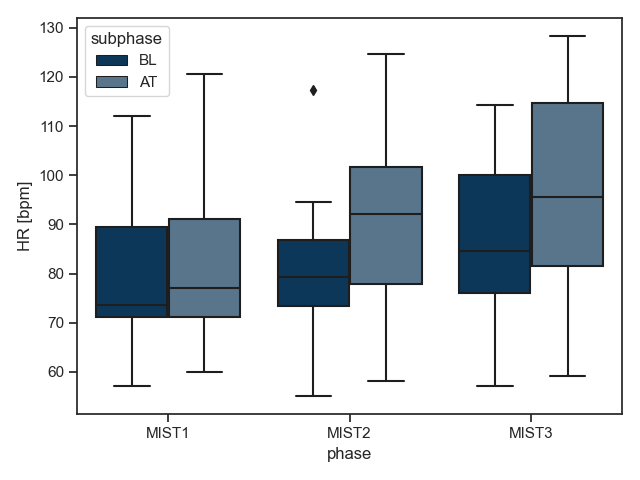

In [10]:
fig, ax = plt.subplots()
sns.boxplot(data=df_analysis.reset_index(), x="phase", y=dv, hue="subphase")
ax.set_ylabel("HR [bpm]")

fig.tight_layout()

**Hinzufügen von Signifikanzklammern**

Mittels der Funktion `add_stat_annotation()` der Bibliothek `statannot` können den Boxplots "Signifikanzklammern" hinzugefügt werden.

Installation: `pip install statannot`  
Dokumentation: https://github.com/webermarcolivier/statannot  
Beispiele: https://github.com/webermarcolivier/statannot/blob/master/example/example.ipynb

`add_stat_annotation()` benötigt eine Liste mit Namen der Boxplot-Paare, über welche Klammern gesetzt werden sollen.  

Listenformat => Aus Dokumentation der Funktion:
* For non-grouped boxplot: `[(cat1, cat2), (cat3, cat4)]`
* For boxplot grouped by hue: `[((cat1, hue1), (cat2, hue2)), ((cat3, hue3), (cat4, hue4))]`

In [11]:
(("MIST1", "BL"), ("MIST1", "AT"))

(('MIST1', 'BL'), ('MIST1', 'AT'))

In [12]:
# Signifikante MIST-Phasen
sig_list = ["MIST1", "MIST2", "MIST3"]
# Konstruieren der Boxplot-Paare-Liste
sig_pairs = [tuple([(sig, sub) for sub in subphases]) for sig in sig_list]
sig_pairs

[(('MIST1', 'BL'), ('MIST1', 'AT')),
 (('MIST2', 'BL'), ('MIST2', 'AT')),
 (('MIST3', 'BL'), ('MIST3', 'AT'))]

#### Boxplot mit Signifikanzklammern

p-value annotation legend:
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: p <= 1.00e-03

MIST2_BL v.s. MIST2_AT: t-test paired samples, P_val=1.889e-03 stat=-3.961e+00
MIST1_BL v.s. MIST1_AT: t-test paired samples, P_val=6.668e-03 stat=-3.273e+00
MIST3_BL v.s. MIST3_AT: t-test paired samples, P_val=3.152e-03 stat=-3.679e+00


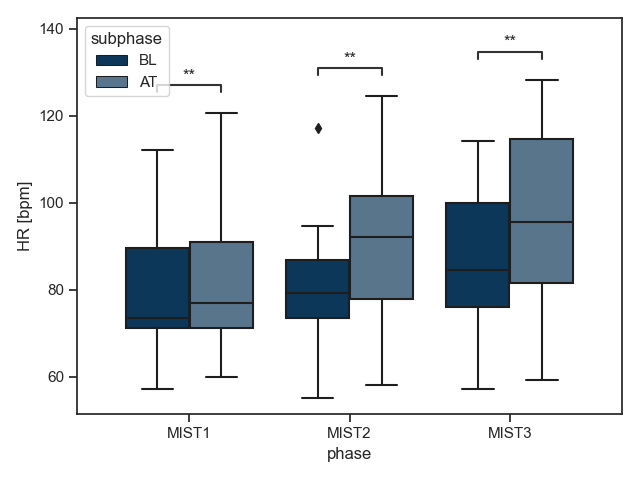

In [13]:
fig, ax = plt.subplots()
sns.boxplot(data=df_analysis.reset_index(), x="phase", y=dv, hue="subphase")
ax.set_ylabel("HR [bpm]")

add_stat_annotation(
    ax=ax, data=df_analysis.reset_index(), 
    x="phase", y=dv, hue="subphase", 
    box_pairs=sig_pairs,
    pvalue_thresholds=pvalue_thres,
    test="t-test_paired",
    comparisons_correction=None
)
fig.tight_layout()

#### Violinplot

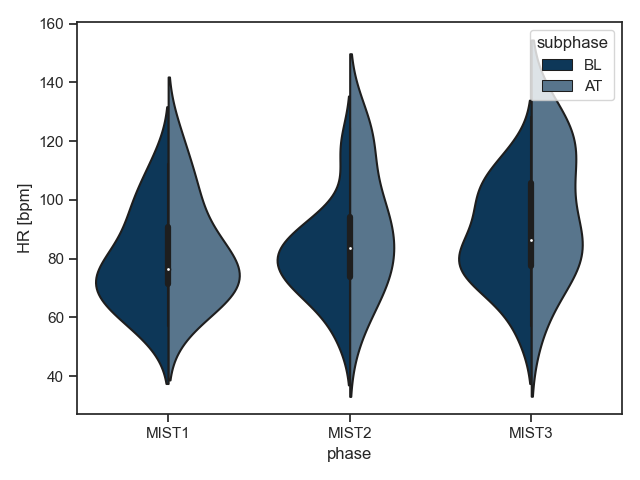

In [14]:
fig, ax = plt.subplots()
sns.violinplot(data=df_analysis.reset_index(), x="phase", y=dv, hue="subphase", split=True)
ax.set_ylabel("HR [bpm]")

fig.tight_layout()

### Fragestellung II: Erhöht sich das Stresslevel im Laufe der drei MIST Phasen?

#### Untersuchung

Bei der *Kontrollgruppe* wird untersucht, ob die Herzrate jeweils in den *BL*, *AT* bzw. *FB*-Phasen im Laufe der Zeit (über die drei MIST-Phasen) signifikant ansteigt.

#### Statistik

##### Analyse

* Vorbereitende Analyse:
    * Test auf Normalverteilung (Shapiro-Wilk-Test)
    * Test auf Varianzgleichheit (Levene-Test)
* *Test*: ANOVA mit Messwiederholung (rm-ANOVA)
* *AV*: HR, jeweils für die Subphasen *BL*, *AT* und *FB* getrennt
* *Innersubjektfaktor*: Phase
* *Maß für Effektstärke*: $\eta_p^{2}$ (partielles eta-quadrat)
* Post-Hoc-Test: t-tests für abhängige Stichproben (einseitig) mit Bonferroni-Korrektur zur Neutralisierung der Alphafehler-Kumulierung bei multiplen Vergleichen

=> Analoge Analyse für die weiteren HRV-Parameter

In [25]:
dv = "HR"
subphases = ["BL", "AT", "FB"]
# Selektieren der zu untersuchenden Daten: Kontrollgruppe, alle Subjects, alle MIST Phasen, Subphasen BL, AT und FB
df_analysis = df_hr[[dv]].loc[pd.IndexSlice["Control", :, :, subphases]]

# Test auf Normalverteilung
df_norm = df_analysis.reset_index().groupby(by=["subphase"]).apply(lambda df: pg.normality(data=df, dv=dv, group="phase"))
# Test auf Homoskedastizität
df_hom = df_analysis.reset_index().groupby(by=["subphase"]).apply(lambda df: pg.homoscedasticity(data=df, dv=dv, group="phase"))

# rm-ANOVA pro Subphase
anova_subph = df_analysis.reset_index().groupby(by=["subphase"]).apply(lambda df: pg.rm_anova(data=df, dv=dv, within="phase", subject="subject"))
# post-hoc
posthoc_subph = df_analysis.reset_index().groupby(by=["subphase"]).apply(lambda df: pg.pairwise_tests(data=df, dv=dv, within="phase", subject="subject", effsize="hedges", padjust='bonf'))

# Ausgabe
display(Markdown("Alle normalverteilt: **{}**".format(df_norm['normal'].all())))
display(Markdown("Alle Varianzen (in etwa) gleich: **{}**".format(df_hom['equal_var'].all())))

display(Markdown("**rm-ANOVA**"))
display(anova_subph.round(3))

display(Markdown("**Post-hoc Tests**"))
display(posthoc_subph.round(3))

# Optional: Filtern der signifikanten Post-Hoc-Tests
#display(posthoc_subph[posthoc_subph['p-corr'] < 0.05].round(3))

Alle normalverteilt: **True**

Alle Varianzen (in etwa) gleich: **True**

**rm-ANOVA**

,,Source,ddof1,ddof2,F,p-unc,ng2,eps
subphase,,,,,,,,
AT,0,phase,2,24,8.432,0.002,0.080,0.948
BL,0,phase,2,24,7.635,0.003,0.043,0.877
FB,0,phase,2,24,8.360,0.002,0.039,0.774


**Post-hoc Tests**

Contrast      A      B  Paired  Parametric      T   dof  \
subphase                                                             
AT       0    phase  MIST1  MIST2    True        True -2.673  12.0   
         1    phase  MIST1  MIST3    True        True -3.962  12.0   
         2    phase  MIST2  MIST3    True        True -1.618  12.0   
BL       0    phase  MIST1  MIST2    True        True -0.586  12.0   
         1    phase  MIST1  MIST3    True        True -4.285  12.0   
         2    phase  MIST2  MIST3    True        True -2.634  12.0   
FB       0    phase  MIST1  MIST2    True        True -1.792  12.0   
         1    phase  MIST1  MIST3    True        True -3.374  12.0   
         2    phase  MIST2  MIST3    True        True -2.606  12.0   

           alternative  p-unc  p-corr p-adjust    BF10  hedges  
subphase                                                        
AT       0   two-sided  0.020   0.061     bonf    3.27  -0.401  
         1   two-sided  0.002   0.006     bonf  23.148  -0.683  
         2   two-sided  0.132   0.395     bonf   0.788  -0.270  
BL       0   two-sided  0.569   1.000     bonf   0.323  -0.071  
         1   two-sided  0.001   0.003     bonf   37.72  -0.438  
         2   two-sided  0.022   0.065     bonf   3.089  -0.384  
FB       0   two-sided  0.098   0.295     bonf   0.972  -0.151  
         1   two-sided  0.006   0.017     bonf   9.428  -0.443  
         2   two-sided  0.023   0.069     bonf   2.965  -0.294

##### Interpretation

Repeated-measures *ANOVA* of HR(V) measures during *MIST subphases* indicate increasing stress levels over time, shown by a significant main effect *MIST Phase* during *BL*, as well as in *FB* and *AT* (see Table 3). Post-hoc testing of HR changes showed significant differences during *BL* between *MIST1* and *MIST3* ($t(12) = −4.285, p = 0.002, g = −0.438$) and between *MIST1* and *MIST2* ($t(12) = −2.634, p = 0.030, g = −0.384$), respectively. […]

#### Plots

p-value annotation legend:
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: p <= 1.00e-03

FB_MIST2 v.s. FB_MIST3: t-test paired samples, P_val=2.296e-02 stat=-2.606e+00
AT_MIST1 v.s. AT_MIST2: t-test paired samples, P_val=2.031e-02 stat=-2.673e+00
BL_MIST2 v.s. BL_MIST3: t-test paired samples, P_val=2.181e-02 stat=-2.634e+00
FB_MIST1 v.s. FB_MIST3: t-test paired samples, P_val=5.527e-03 stat=-3.374e+00
AT_MIST1 v.s. AT_MIST3: t-test paired samples, P_val=1.886e-03 stat=-3.962e+00
BL_MIST1 v.s. BL_MIST3: t-test paired samples, P_val=1.059e-03 stat=-4.285e+00


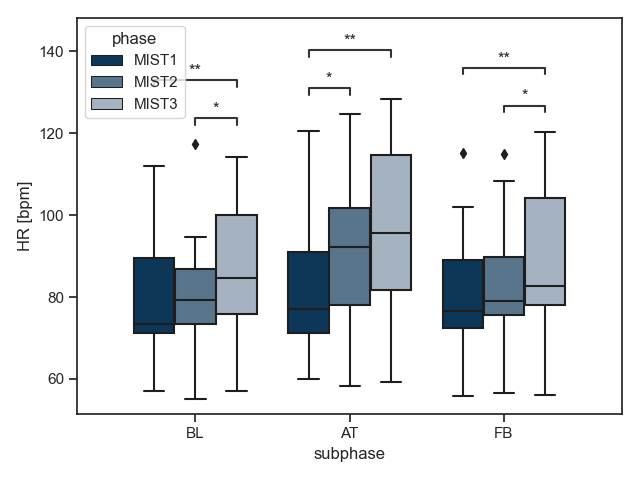

In [16]:
fig, ax = plt.subplots()
sns.boxplot(data=df_analysis.reset_index(), x="subphase", y=dv, hue="phase")

sig_pairs = [
    (("AT", "MIST1"), ("AT", "MIST2")),
    (("AT", "MIST1"), ("AT", "MIST3")),
    (("BL", "MIST1"), ("BL", "MIST3")),
    (("BL", "MIST2"), ("BL", "MIST3")),
    (("FB", "MIST1"), ("FB", "MIST3")),
    (("FB", "MIST2"), ("FB", "MIST3")),
]

add_stat_annotation(
    ax=ax, data=df_analysis.reset_index(), 
    x="subphase", y=dv, hue="phase", 
    box_pairs=sig_pairs,
    pvalue_thresholds=pvalue_thres,
    test="t-test_paired",
    comparisons_correction=None
)

ax.set_ylabel("HR [bpm]")

fig.tight_layout()

### Fragestellung III: Verschlechtert der MIST die Stimmung?

#### Untersuchung

Bei der *Kontrollgruppe* wird untersucht, ob sich die Stimmung (gemessen mittels MDBF) als Reaktion auf den MIST signifikant verschlechtert hat.

#### Statistik

##### Analyse
* Vorbereitende Analyse:
    * Test auf Normalverteilung (Shapiro-Wilk-Test)
* *Test*: Gepaarte t-tests
* *AV*: MDBF-Skalen
* *Innersubjektfaktor*: Zeit (pre/post)
* *Maß für Effektstärke*: Hedge's g

In [17]:
df_mood.head()

MDBF
condition    subject time type              
Intervention 1       pre  awake_tired     29
                          calm_nervous    32
                          good_bad        34
                     post awake_tired     30
                          calm_nervous    28

In [18]:
#df_analysis.unstack(level='time')

In [26]:
dv = "MDBF"
# Selektieren der zu untersuchenden Daten: Kontrollgruppe
df_analysis = df_mood.xs("Control")

# Test auf Normalverteilung
df_norm = df_analysis.reset_index().groupby(by=["type"]).apply(lambda df: pg.normality(data=df, dv=dv, group="time"))

# gepaarte t-tests pro MDBF Subskala
ttests = df_analysis.reset_index().groupby(["type"]).apply(lambda df: pg.pairwise_tests(data=df.reset_index(), within="time", dv=dv, subject="subject", effsize="hedges"))

# Berechnen der prozentualen Verschlechterung der Stimmung
df_decrease = pd.DataFrame(df_analysis.unstack(level='time').groupby("type").apply(lambda x: (x[("MDBF", 'post')] / x[("MDBF", 'pre')] - 1.0) * 100.0), columns=["decrease_percent"])
df_decrease = df_decrease.groupby("type").agg(['mean', 'std'])

# Ausgabe
display(Markdown("Alle normalverteilt: **{}**".format(df_norm['normal'].all())))
display(df_norm)

display(Markdown("**Gepaarte t-tests**"))
display(ttests.round(3))

display(Markdown("**Verschlechterung der Stimmung (Mean ± SD)**"))
display(df_decrease.T.round(2))

Alle normalverteilt: **True**

W      pval  normal
type         time                            
awake_tired  pre   0.920201  0.252422    True
             post  0.930938  0.350563    True
calm_nervous pre   0.944346  0.515582    True
             post  0.963465  0.806082    True
good_bad     pre   0.942407  0.488819    True
             post  0.908637  0.175675    True

**Gepaarte t-tests**

,,Contrast,A,B,Paired,Parametric,T,dof,alternative,p-unc,BF10,hedges
type,,,,,,,,,,,,
awake_tired,0,time,post,pre,True,True,-3.169,12.0,two-sided,0.008,6.89,-0.615
calm_nervous,0,time,post,pre,True,True,-5.094,12.0,two-sided,0.000,124.047,-1.855
good_bad,0,time,post,pre,True,True,-5.761,12.0,two-sided,0.000,315.833,-2.105


**Verschlechterung der Stimmung (Mean ± SD)**

type                   awake_tired  calm_nervous  good_bad
decrease_percent mean       -12.45        -35.44    -36.93
                 std         13.28         23.92     22.26

##### Interpretation

"The stress-inducing effects of the *MIST* in the *Control* group were further confirmed by the MDBF questionnaire. Mood worsened significantly in all MDBF dimensions as indicated by pairwise t-tests (*Good-Bad*: $t(12) = 5.761, p < 0.001, g = 2.105$, decrease: $36.93\%±22.26\%~(\text{M}±\text{SD})$; *Awake-Tired*: $t(12) = 3.169, p = 0.008, g = 0.615$, decrease: $12.45\% ± 13.28\%$; *Calm-Nervous*: $t(12) = 5.094, p < 0.001, g = 1.855$, decrease: $35.44\% ± 23.92\%$)."

#### Plots

p-value annotation legend:
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: p <= 1.00e-03

awake_tired_pre v.s. awake_tired_post: t-test paired samples, P_val=8.089e-03 stat=3.169e+00
good_bad_pre v.s. good_bad_post: t-test paired samples, P_val=9.008e-05 stat=5.761e+00
calm_nervous_pre v.s. calm_nervous_post: t-test paired samples, P_val=2.643e-04 stat=5.094e+00


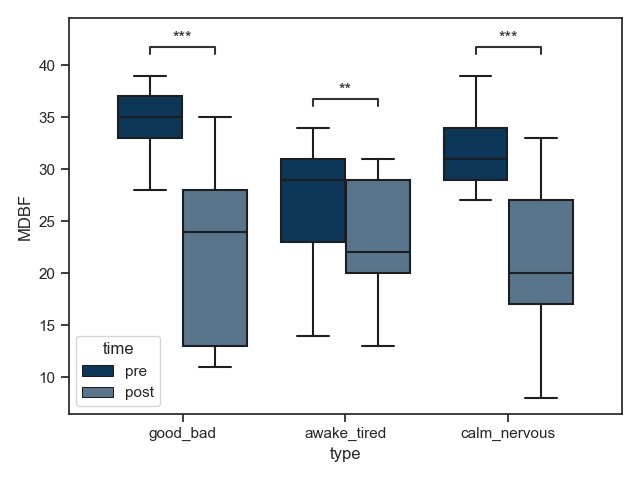

In [20]:
fig, ax = plt.subplots()
x_order = ["good_bad", "awake_tired", "calm_nervous"]
sns.boxplot(data=df_analysis.reset_index(), x="type", y=dv, hue="time", order=x_order)

sig_pairs = [
    (("good_bad", "pre"), ("good_bad", "post")),
    (("awake_tired", "pre"), ("awake_tired", "post")),
    (("calm_nervous", "pre"), ("calm_nervous", "post")),
]

add_stat_annotation(
    ax=ax, data=df_analysis.reset_index(), 
    x="type", y=dv, hue="time", 
    order=x_order,
    box_pairs=sig_pairs,
    pvalue_thresholds=pvalue_thres,
    test="t-test_paired",
    comparisons_correction=None
)

fig.tight_layout()

### Fragestellung IV: Erzeugt der MIST eine signifikante endokrine Stressreaktion?

#### Untersuchung

Bei der *Kontrollgruppe* wird untersucht, ob sich der Cortisolspiegel vor (S1) und nach dem Stressor (S2-S6) signifikant erhöht hat.

#### Statistik

##### Analyse
* Vorbereitende Analyse:
    * Test auf Normalverteilung (Shapiro-Wilk-Test)
* *Test*: Gepaarte t-tests
* *AV*: Cortisol
* *Innersubjektfaktor*: Zeit (pre/post)
* *Maß für Effektstärke*: Hedge's g

In [21]:
df_cort_inc.head()

cortisol
condition subject time          
Control   3       pre   13.27400
                  post  14.23000
          6       pre    6.20725
                  post  15.65350
          8       pre    2.49575

In [27]:
dv = "cortisol"
# Selektieren der zu untersuchenden Daten: Kontrollgruppe
df_analysis = df_cort_inc.xs("Control")

# Test auf Normalverteilung
df_norm = pg.normality(data=df_analysis.reset_index(), dv=dv, group="time")

# gepaarte t-tests
ttests = pg.pairwise_tests(data=df_analysis.reset_index(), dv=dv, within="time", subject="subject", effsize="hedges")

# Berechnen des prozentualen Cortisolanstiegs
df_increase = df_analysis.unstack(level='time')
df_increase = pd.DataFrame((df_increase[("cortisol", "post")] / df_increase[("cortisol", "pre")] - 1.0) * 100, columns=["increase_percent"])

# Ausgabe
display(Markdown("Alle normalverteilt: **{}**".format(df_norm['normal'].all())))

display(Markdown("**Gepaarte t-tests**"))
display(ttests.round(3))

display(Markdown("**Cortisolanstieg**"))
display(df_increase.mean().round(2))

Alle normalverteilt: **True**

**Gepaarte t-tests**

,Contrast,A,B,Paired,Parametric,T,dof,alternative,p-unc,BF10,hedges
0,time,post,pre,True,True,2.284,12.0,two-sided,0.041,1.869,0.623


**Cortisolanstieg**

increase_percent    75.38
dtype: float64

##### Interpretation

"Analysis of saliva samples showed that the *Control* group overall responded to the stressor. On average, cortisol levels increased significantly after the *MIST* ($t(12) = -2.284, p = 0.041, g = -0.623$) with an maximum increase of $75.4\%$ compared to S1."

## Effekt der Intervention auf akute Stressreaktionen

### Fragestellung I: Induziert der MIST auch in der Interventionsgruppe eine signifikante kardiovaskuläre Stressreaktion?

#### Untersuchung

Bei der *Interventionsgruppe* wird für jede MIST-Phase gesondert untersucht, ob die Herzrate zwischen den Subphasen *BL* und *AT* signifikant ansteigt.

#### Statistik

##### Analyse

* Vorbereitende Analyse:
    * Test auf Normalverteilung (Shapiro-Wilk-Test)
* *Test*: Gepaarte t-tests
* *AV*: HR
* *Innersubjektfaktor*: Subphase
* *Maß für Effektstärke*: Hedge's g (bzw. Common Language Effect Size (CLES) bei Wilcoxon-Test)

=> Analoge Analyse für die weiteren HRV-Parameter (signifikante Verringerung der HRV während Stress?)

In [29]:
dv = "HR"
subphases = ["BL", "AT"]
# Selektieren der zu untersuchenden Daten: Kontrollgruppe, alle Subjects, alle MIST Phasen, Subphasen BL und AT
df_analysis = df_hr[[dv]].loc[pd.IndexSlice["Intervention", :, :, subphases]]

# Test auf Normalverteilung
df_norm = df_analysis.reset_index().groupby("phase").apply(
    lambda df: pg.normality(data=df, dv=dv, group="subphase")
)

# Wilcoxon-Tests pro MIST-Phase
wilc_phase = df_analysis[dv].groupby("phase").apply(
    lambda df: pg.wilcoxon(
        x=df.xs("BL", level="subphase"), 
        y=df.xs("AT", level="subphase"),
    )
)

# Zum Vergleich: gepaarte t-tests pro MIST-Phase
tt_phase = df_analysis.reset_index().groupby("phase").apply(
    lambda df: pg.pairwise_tests(
        data=df, dv=dv, within="subphase", 
        subject="subject", effsize="hedges"
    )
)

# Ausgabe
display(Markdown("Alle normalverteilt: **{}**".format(df_norm['normal'].all())))
display(df_norm)
display(Markdown("Normalverteilung **nicht** für **alle** Verteilungen gegeben => *Wilcoxon-Test* statt gepaartem t-test"))

display(Markdown("**Wilcoxon-Tests**"))
display(wilc_phase.round(3))
display(Markdown("**Zum Vergleich: gepaarte t-tests** (liefert vergleichbare Ergebnisse)"))
display(tt_phase.round(3))

Alle normalverteilt: **False**

W      pval  normal
phase subphase                            
MIST1 BL        0.916817  0.227160    True
      AT        0.899550  0.131842    True
MIST2 BL        0.912692  0.199600    True
      AT        0.938626  0.439357    True
MIST3 BL        0.840716  0.021646   False
      AT        0.944529  0.518142    True

Normalverteilung **nicht** für **alle** Verteilungen gegeben => *Wilcoxon-Test* statt gepaartem t-test

**Wilcoxon-Tests**

,,W-val,alternative,p-val,RBC,CLES
phase,,,,,,
MIST1,Wilcoxon,32.0,two-sided,0.376,-0.297,0.432
MIST2,Wilcoxon,5.0,two-sided,0.002,-0.890,0.254
MIST3,Wilcoxon,0.0,two-sided,0.000,-1.000,0.160


**Zum Vergleich: gepaarte t-tests** (liefert vergleichbare Ergebnisse)

,,Contrast,A,B,Paired,Parametric,T,dof,alternative,p-unc,BF10,hedges
phase,,,,,,,,,,,,
MIST1,0,subphase,AT,BL,True,True,0.733,12.0,two-sided,0.477,0.351,0.082
MIST2,0,subphase,AT,BL,True,True,2.796,12.0,two-sided,0.016,3.929,0.792
MIST3,0,subphase,AT,BL,True,True,4.466,12.0,two-sided,0.001,49.46,1.091


##### Interpretation

"Even though the HR of the Intervention group was slightly decreased compared to the *Control* group during the *AT* and *FB* sub-phases both groups reached comparable stress levels especially during *MIST2* and *MIST3*. This finding is supported by significant HR increases during *AT* in each *MIST* phase for both groups (*Control*: Table 2, *Intervention*: Table 5). […] Thus, the MIST successfully caused sympathetic activation during *AT* and *FB* regardless of the condition."

### Fragestellung II: Zeigt die Intervention einen Effekt auf die kardiovaskuläre Stressreaktion?

#### Untersuchung – I

Es wird untersucht, ob die Intervention signifikante Unterschiede zwischen den beiden Gruppen während des MIST während der *BL*-Subphase verursacht.

#### Statistik

##### Analyse

* Vorbereitende Analyse:
    * Test auf Normalverteilung (Shapiro-Wilk-Test)
    * Test auf Varianzgleichheit (Levene-Test)
* *Test*: Mixed ANOVA
* *AV*: $\text{HR}_{rel}$ (normalisierte Herzrate) während *BL* => da in dieser Analyse nicht mehr ausschließlich Innersubjektfaktoren (Messwiederholung) betrachtet werden, sondern Gruppenvergleiche
* *Innersubjektfaktor*: Phase
* *Zwischensubjektfaktor*: Gruppe
* *Maß für Effektstärke*: $\eta_p^2$

=> Analoge Analyse für die weiteren HRV-Parameter

**Baseline**

In [30]:
dv = "HR_rel"

df_analysis = df_hr.xs("BL", level='subphase')

# Test auf Normalverteilung
df_norm = df_analysis.reset_index().groupby(by=["phase"]).apply(lambda df: pg.normality(data=df, dv=dv, group="condition"))
# Test auf Homoskedastizität
df_hom = df_analysis.reset_index().groupby(by=["phase"]).apply(lambda df: pg.homoscedasticity(data=df, dv=dv, group="condition"))

# Mixed ANOVA
anova_mixed = pg.mixed_anova(data=df_analysis.reset_index(), dv=dv, within="phase", between="condition", subject="subject")
# Post-hoc Tests
posthoc_mixed = pg.pairwise_tests(data=df_analysis.reset_index(), dv=dv, within="phase", between="condition", subject="subject", effsize="hedges", padjust='bonf')

# Ausgaben
display(Markdown("Alle normalverteilt: **{}**".format(df_norm['normal'].all())))
display(df_norm.round(3))
display(Markdown("Alle Varianzen (in etwa) gleich: **{}**".format(df_hom['equal_var'].all())))

display(Markdown("**Mixed ANOVA**"))
display(anova_mixed.round(3))

display(Markdown("**Post-hoc Tests**"))
display(Markdown("Signifikanter Interaktionseffekt => Betrachten der Gruppenunterschiede zu jedem Zeitpunkt (phase * condition))"))
display(posthoc_mixed.round(3))

Alle normalverteilt: **False**

W   pval  normal
phase condition                         
MIST1 Intervention  0.974  0.941    True
      Control       0.956  0.697    True
MIST2 Intervention  0.954  0.665    True
      Control       0.983  0.991    True
MIST3 Intervention  0.845  0.025   False
      Control       0.888  0.092    True

Alle Varianzen (in etwa) gleich: **True**

**Mixed ANOVA**

,Source,SS,DF1,DF2,MS,F,p-unc,np2,eps
0,condition,924.742,1,24,924.742,9.071,0.006,0.274,NaN
1,phase,394.020,2,48,197.010,6.692,0.003,0.218,0.934
2,Interaction,304.265,2,48,152.132,5.167,0.009,0.177,NaN


**Post-hoc Tests**

Signifikanter Interaktionseffekt => Betrachten der Gruppenunterschiede zu jedem Zeitpunkt (phase * condition))

,Contrast,phase,A,B,Paired,Parametric,T,dof,alternative,p-unc,p-corr,p-adjust,BF10,hedges
0,phase,-,MIST1,MIST2,True,True,-0.206,25.0,two-sided,0.838,1.000,bonf,0.211,-0.045
1,phase,-,MIST1,MIST3,True,True,-2.952,25.0,two-sided,0.007,0.020,bonf,6.565,-0.532
2,phase,-,MIST2,MIST3,True,True,-2.589,25.0,two-sided,0.016,0.047,bonf,3.215,-0.506
3,condition,-,Control,Intervention,False,True,3.012,24.0,two-sided,0.006,NaN,NaN,7.498,1.144
4,phase * condition,MIST1,Control,Intervention,False,True,1.109,24.0,two-sided,0.279,0.836,bonf,0.569,0.421
5,phase * condition,MIST2,Control,Intervention,False,True,2.535,24.0,two-sided,0.018,0.055,bonf,3.314,0.963
6,phase * condition,MIST3,Control,Intervention,False,True,3.343,24.0,two-sided,0.003,0.008,bonf,13.882,1.270


##### Interpretation

"Over the three *MIST* phases the *HR* during *BL* of the *Intervention* group remained roughly constant, whereas it showed strong increases over time in the *Control* group (Figure 5). This drift of baseline levels in the *Control* group is reflected by a significant interaction of *condition* and *MIST Phase* in HR and (Table 6). Post-hoc tests in Table 7 revealed that baselines started to significantly differ in *MIST2* and continued for *MIST3*."

#### Plots

In [ ]:
fig, ax = plt.subplots()
sns.boxplot(data=df_analysis.reset_index(), x="phase", y=dv, hue="condition", hue_order=["Control", "Intervention"], ax=ax)

sig_pairs = [
    (("MIST2", "Control"), ("MIST2", "Intervention")),
    (("MIST3", "Control"), ("MIST3", "Intervention")),
]

add_stat_annotation(
    ax=ax, data=df_analysis.reset_index(), 
    x="phase", y=dv, hue="condition", 
    box_pairs=sig_pairs,
    pvalue_thresholds=pvalue_thres,
    test="t-test_ind",
    hue_order=["Control", "Intervention"],
    comparisons_correction='bonferroni'
)

ax.set_title("Relative Heart Rate during BL")
ax.set_ylabel("$\Delta HR~[\%]$")
fig.tight_layout()

#### Untersuchung – II

Es wird untersucht, ob die Intervention signifikante Unterschiede zwischen den beiden Gruppen während des MIST während der *CFI*-Subphase verursacht.

#### Statistik

##### Analyse

* Vorbereitende Analyse:
    * Test auf Normalverteilung (Shapiro-Wilk-Test)
    * Test auf Varianzgleichheit (Levene-Test)
* *Test*: Mixed ANOVA
* *AV*: $\text{HR}_{rel}$ (normalisierte Herzrate) während *CFI* => da in dieser Analyse nicht mehr ausschließlich Innersubjektfaktoren (Messwiederholung) betrachtet werden, sondern Gruppenvergleiche
* *Innersubjektfaktor*: Phase
* *Zwischensubjektfaktor*: Gruppe
* *Maß für Effektstärke*: $\eta_p^2$

=> Analoge Analyse für die weiteren HRV-Parameter

In [ ]:
dv = "HR_rel"

df_analysis = df_hr.xs("CFI", level='subphase')

# Test auf Normalverteilung
df_norm = df_analysis.reset_index().groupby(by=["phase"]).apply(lambda df: pg.normality(data=df, dv=dv, group="condition"))
# Test auf Homoskedastizität
df_hom = df_analysis.reset_index().groupby(by=["phase"]).apply(lambda df: pg.homoscedasticity(data=df, dv=dv, group="condition"))

# Mixed ANOVA
anova_mixed = pg.mixed_anova(data=df_analysis.reset_index(), dv=dv, within="phase", between="condition", subject="subject")

# Ausgaben
display(Markdown("Alle normalverteilt: **{}**".format(df_norm['normal'].all())))
display(df_norm.round(3))
display(Markdown("Alle Varianzen (in etwa) gleich: **{}**".format(df_hom['equal_var'].all())))

display(Markdown("**Mixed ANOVA**"))
display(anova_mixed.round(3))

##### Interpretation

"For the *CFI/RP* sub-phase ANOVA revealed no significant interaction effects, but significant main effects for *condition* (Table 6). These findings indicate that the Intervention group recovered better from acute stress than the Control group."

#### Plots

In [ ]:
dv = "HR_rel"
df_plot = df_hr.loc[pd.IndexSlice[:, :, :, ["BL", "CFI"]]]
fig, axs = plt.subplots(figsize=(10, 5), ncols=2)

for (key, df), ax in zip(df_plot.reset_index().groupby("subphase"), axs):
    sns.violinplot(data=df, x="phase", y=dv, hue="condition", hue_order=["Control", "Intervention"], split=True, ax=ax)
    ax.set_title("Relative Heart Rate during {}".format(key))
    ax.set_ylabel("$\Delta HR~[\%]$")

fig.tight_layout()

### Fragestellung III: Zeigt die Intervention einen Effekt auf die Stimmungsverschlechterung?

#### Untersuchung

Es wird untersucht, ob die Intervention signifikante Unterschiede zwischen den beiden Gruppen hinsichtlich der stressinduzierten Verschlechterung der Stimmung erzeugt.

#### Statistik

##### Analyse
* Vorbereitende Analyse:
    * Test auf Normalverteilung (Shapiro-Wilk-Test)
    * Test auf Varianzgleichheit (Levene-Test)
* *Test*: Mixed ANOVA
* *AV*: MDBF-Subskalen
* *Innersubjektfaktor*: Zeit
* *Zwischensubjektfaktor*: Gruppe
* *Maß für Effektstärke*: $\eta_p^2$

In [33]:
df_mood.head()

MDBF
condition    subject time type              
Intervention 1       pre  awake_tired     29
                          calm_nervous    32
                          good_bad        34
                     post awake_tired     30
                          calm_nervous    28

In [34]:
dv = "MDBF"
# Selektieren der zu untersuchenden Daten
df_analysis = df_mood


# Test auf Normalverteilung
df_norm = df_analysis.reset_index().groupby(by=["type", "time"]).apply(lambda df: pg.normality(data=df, dv=dv, group="condition"))
# Test auf Homoskedastizität
df_homo = df_analysis.reset_index().groupby(by=["type", "time"]).apply(lambda df: pg.homoscedasticity(data=df, dv=dv, group="condition"))

# Mixed ANOVA pro MDBF-Subskala
anova_mixed = df_analysis.reset_index().groupby(by=["type"]).apply(lambda df: pg.mixed_anova(data=df, dv=dv, within="time", between="condition", subject="subject"))

# Ausgabe
display(Markdown("Alle normalverteilt: **{}**".format(df_norm['normal'].all())))
display(Markdown("Alle Varianzen (in etwa) gleich: **{}**".format(df_hom['equal_var'].all())))

display(Markdown("**Mixed ANOVA**"))
display(anova_mixed.round(3))

Alle normalverteilt: **True**

Alle Varianzen (in etwa) gleich: **True**

**Mixed ANOVA**

Source        SS  DF1  DF2        MS       F  p-unc  \
type                                                                       
awake_tired  0    condition    66.942    1   24    66.942   1.480  0.236   
             1         time   126.173    1   24   126.173   9.461  0.005   
             2  Interaction     3.250    1   24     3.250   0.244  0.626   
calm_nervous 0    condition    58.173    1   24    58.173   1.183  0.288   
             1         time  1310.019    1   24  1310.019  50.472  0.000   
             2  Interaction    23.558    1   24    23.558   0.908  0.350   
good_bad     0    condition    33.923    1   24    33.923   0.722  0.404   
             1         time  2043.769    1   24  2043.769  64.455  0.000   
             2  Interaction     1.231    1   24     1.231   0.039  0.845   

                  np2  eps  
type                        
awake_tired  0  0.058  NaN  
             1  0.283  1.0  
             2  0.010  NaN  
calm_nervous 0  0.047  NaN  
             1  0.678  1.0  
             2  0.036  NaN  
good_bad     0  0.029  NaN  
             1  0.729  1.0  
             2  0.002  NaN

##### Interpretation

"Subjects in the Intervention group experienced slightly decreased mood worsening compared to the Control group, especially in the *Awake-Tired* dimension (Control: $12.45\% ± 13.28\%$; Intervention: $7.84\% ± 20.38\%$). However, ANOVA revealed no significant interaction effects (*condition* by *time*) and no significant main effects for *conditon*."

### Fragestellung IV: Zeigt die Intervention einen Effekt auf die endokrine Stressreaktion?

#### Untersuchung – I

Es wird untersucht, ob die Intervention signifikante Unterschiede zwischen den beiden Gruppen hinsichtlich der endokrinen Stressreaktion erzeugt.

#### Statistik

##### Analyse
* Vorbereitende Analyse:
    * Test auf Normalverteilung (Shapiro-Wilk-Test)
* *Test*: Unabhängiger t-test (beidseitig)
* *AVs*: 
    * $\text{max_inc}$ (maximaler Cortisolanstieg in Prozent)
    * $AUC_g$
    * $AUC_i$
    * $a_{S1S4}$
* *Maß für Effektstärke*: Hedge's g

=> Analog für andere Cortisol-Parameter ($\text{AUC}_g$, $\text{AUC}_i$, slope $a_{s1s4}$, ...)

In [31]:
df_cort

cortisol
condition    subject saliva_feature              
Control      3       auc_g            1110.809250
                     auc_i             587.154750
                     max_inc_percent   163.591738
                     slope14             0.014250
             6       auc_g             884.624825
...                                           ...
Intervention 27      slope14             0.074584
             28      auc_g             491.018225
                     auc_i             -73.250175
                     max_inc_percent    -0.645500
                     slope14             0.008629

[104 rows x 1 columns]

In [32]:
df_analysis

HR       RMSSD      pNN50   SD1/SD2  \
condition    subject phase                                               
Intervention 1       MIST1  92.267432   22.554093   5.494505  0.320845   
                     MIST2  91.489228   20.316695   0.000000  0.297082   
                     MIST3  88.157295   30.337048  10.465116  0.365427   
             2       MIST1  85.827190   34.668525  17.294118  0.437566   
                     MIST2  88.517701   30.726213  12.298851  0.427402   
...                               ...         ...        ...       ...   
Control      32      MIST2  73.434277   43.448736  16.527778  0.319407   
                     MIST3  87.932413   23.717027   5.747126  0.242635   
             33      MIST1  57.069784  100.161743  57.931034  0.754742   
                     MIST2  55.038165   63.732003  43.518519  0.885644   
                     MIST3  57.114617   45.500798  19.122807  1.140932   

                               HR_rel  RMSSD_rel   pNN50_rel  SD1/SD2_rel  
condition    subject phase                                                 
Intervention 1       MIST1  -4.601992  10.334854   51.865576    23.095973  
                     MIST2  -5.406600  -0.610524 -100.000000    13.979008  
                     MIST3  -8.851584  48.409147  189.250946    40.200361  
             2       MIST1  -2.159420   6.776223   23.777090    38.691744  
                     MIST2   0.907686  -5.365775  -11.974929    35.470168  
...                               ...        ...         ...          ...  
Control      32      MIST2  -0.800590  29.741382   27.102507    -2.385989  
                     MIST3  18.784358 -29.179071  -55.803243   -25.848446  
             33      MIST1   2.981413  45.340896   42.042855    59.394213  
                     MIST2  -0.684607  -7.520914    6.704372    87.039471  
                     MIST3   3.062315 -33.975522  -53.112211   140.953802  

[78 rows x 8 columns]

In [35]:
dv = "cortisol"
biomarker = ["max_inc_percent", "auc_g", "auc_i", "slope14"]
df_analysis = df_cort.loc[pd.IndexSlice[:, :, biomarker]]

# Test auf Normalverteilung
df_norm = df_analysis.reset_index().groupby("saliva_feature").apply(lambda df: pg.normality(data=df, dv=dv, group="condition"))
df_norm_grp = pd.DataFrame(df_norm.reset_index().groupby("saliva_feature").apply(lambda df: df['normal'].all())).T

display(df_norm)
display(df_norm_grp)

# t-tests pro Biomarker
ttest_group = df_analysis.reset_index().groupby("saliva_feature").apply(lambda df: pg.pairwise_ttests(data=df, dv=dv, between="condition", subject="subject", effsize="hedges"))
# Mann-Whitney-U-Tests pro Biomarker
mwu_group = df_analysis[dv].groupby(by="saliva_feature").apply(lambda df: pg.mwu(x=df.xs("Control", level="condition"), y=df.xs("Intervention", level="condition")))

# Ausgaben
display(Markdown("Alle normalverteilt: **{}**".format(df_norm['normal'].all())))
display(Markdown("Normalverteilung **nicht** für **alle** Verteilungen gegeben => *Mann-Whitney-U-Test* statt t-test bei den nicht-normalverteilten Variablen"))

for bm in biomarker:
    is_normal = df_norm_grp[bm].all()
    display(Markdown("* *{}* => Normal: **{}**".format(bm, is_normal)))
    if is_normal:
        display(ttest_group.loc[bm])
    else:
        display(mwu_group.loc[bm])

#display(Markdown("**Mann-Whitney-U-Tests**"))
#display(mwu_group.round(3))
#display(Markdown("**t-tests**"))
#display(ttest_group.round(3))

W      pval  normal
saliva_feature  condition                               
auc_g           Control       0.907978  0.172058    True
                Intervention  0.924859  0.291481    True
auc_i           Control       0.934122  0.385404    True
                Intervention  0.930669  0.347747    True
max_inc_percent Control       0.885961  0.085924    True
                Intervention  0.637620  0.000141   False
slope14         Control       0.857235  0.035428   False
                Intervention  0.965331  0.833045    True

saliva_feature,auc_g,auc_i,max_inc_percent,slope14
0,True,True,False,False


/Users/abelluc/Code/ma-luca-abel/Code/empkins-d03-macro-analysis-luca/.venv/lib/python3.9/site-packages/pingouin/pairwise.py:28: UserWarning: pairwise_ttests is deprecated, use pairwise_tests instead.
  warnings.warn("pairwise_ttests is deprecated, use pairwise_tests instead.", UserWarning)


Alle normalverteilt: **False**

Normalverteilung **nicht** für **alle** Verteilungen gegeben => *Mann-Whitney-U-Test* statt t-test bei den nicht-normalverteilten Variablen

* *max_inc_percent* => Normal: **False**

,U-val,alternative,p-val,RBC,CLES
MWU,141.0,two-sided,0.004081,-0.668639,0.83432


* *auc_g* => Normal: **True**

,Contrast,A,B,Paired,Parametric,T,dof,alternative,p-unc,BF10,hedges
0,condition,Control,Intervention,False,True,0.514951,24.0,two-sided,0.611298,0.4,0.195602


* *auc_i* => Normal: **True**

,Contrast,A,B,Paired,Parametric,T,dof,alternative,p-unc,BF10,hedges
0,condition,Control,Intervention,False,True,2.410028,24.0,two-sided,0.023977,2.718,0.915439


* *slope14* => Normal: **False**

,U-val,alternative,p-val,RBC,CLES
MWU,126.0,two-sided,0.035504,-0.491124,0.745562


##### Interpretation

"Subjects in the Intervention group had significantly lower maximum cortisol responses compared to the Control group ($t(24) = 2.505, p = 0.019, d = 0.952$)."

#### Plots

In [ ]:
fig, axs = plt.subplots(ncols=len(biomarker), figsize=(12,5))
xlabel_map = {
    'auc_g': r"$AUC_G$",
    'auc_i': r"$AUC_I$",
    'max_inc_percent': r"$Inc_{max}$",
    'slope14': r"$a_{S1S4}$",
}
ylabel_map = {
    'auc_g': r"Cortisol AUC $\left[\frac{nmol \cdot min}{l}\right]$",
    'auc_i': r"Cortisol AUC $\left[\frac{nmol \cdot min}{l}\right]$",
    'max_inc_percent': r"Cortisol Change $[\%]$",
    'slope14': r"Cortisol Change $\left[\frac{nmol}{l \cdot min}\right]$",
}

for (key, df), ax in zip(df_analysis.reset_index().groupby("saliva_feature"), axs):
    sns.boxplot(data=df, x="condition", y="cortisol", ax=ax)
    ax.set_xlabel(xlabel_map[key])
    ax.set_ylabel(ylabel_map[key])
    

# stat annotation for significant features
for bm, i, test in zip(["max_inc_percent", "slope14"], [2, 3], ["t-test_ind", "Mann-Whitney"]):   
    add_stat_annotation(
        ax=axs[i], data=df_analysis.xs(bm, level="saliva_feature").reset_index(),
        x="condition", y=dv, 
        box_pairs=[("Control", "Intervention")],
        pvalue_thresholds=pvalue_thres,
        test=test,
        order=["Control", "Intervention"]
    )

fig.tight_layout()

#### Untersuchung – II
Es wird untersucht, ob die Intervention den Cortisolverlauf beeinflusst.

#### Statistik

##### Analyse
* Vorbereitende Analyse:
    * Test auf Normalverteilung (Shapiro-Wilk-Test)
    * Test auf Varianzgleichheit (Levene-Test)
* *Test*: Mixed ANOVA
* *AV*: Cortisol-Rohwerte
* *Maß für Effektstärke*: $\eta_p^2$

In [ ]:
dv = "cortisol"
# Entfernen von S0
df_analysis = df_cort_raw.drop('0', level='sample')

# Test auf Normalverteilung
df_norm = df_analysis.reset_index().groupby("sample").apply(lambda df: pg.normality(data=df, dv=dv, group="condition"))
# Test auf Homoskedastizität
df_hom = df_analysis.reset_index().groupby("sample").apply(lambda df: pg.homoscedasticity(data=df, dv=dv, group="condition"))

anova_mixed = pg.mixed_anova(data=df_analysis.reset_index(), dv=dv, between="condition", within="sample", subject="subject")

# Ausgaben
display(Markdown("Alle normalverteilt: **{}**".format(df_norm['normal'].all())))
display(df_norm.round(3))
display(Markdown("Alle Varianzen (in etwa) gleich: **{}**".format(df_hom['equal_var'].all())))

display(anova_mixed.round(3))

##### Interpretation

ANOVA further showed a significant interaction of *condition* by *time* for raw cortisol samples ($F(5,120) = 3.839, p = 0.003, \eta_p^2 = 0.138$).